In [2]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio 
import io

In [3]:
#0, position, min = -1.2, max = 0.6
#1, velocity, min = -0.07, max = 0.07


In [4]:
#state = position, velocity
def get_mountain_car_data(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    actions = [-1,0,1] #left, none, right
    for position in position_linspace:
        for velocity in velocity_linspace:
            for action in actions:
                state = torch.tensor([position, velocity],dtype=torch.float32)
                next_velocity =  velocity + force*(action) - gravity*np.cos(3*position)
                next_position = position + next_velocity
                next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
                a = torch.tensor([action],dtype=torch.float32)

                data.append((state, a, next_state))
    return data

In [5]:

class LQR(nn.Module):
    def __init__(self, enc_dim,state_in_dim, action_in_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.B = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))

        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(state_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, state_in_dim)
        )

        self.action_encoder = torch.nn.Sequential(
            torch.nn.Linear(action_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.action_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, action_in_dim)
        )

    def forward (self,x,u):
        xx = self.state_encoder(x)
        uu = self.action_encoder(u)
        x_prime_prediction = self.A @ xx + self.B @ uu
       # print(uu.shape)
        decode_action = self.action_decoder(uu)
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, decode_action

In [6]:
def train_model(model,optimizer,train_data_loader,test_data,epochs=1):
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        total_action_loss = 0
        counter = 0
        for x, u, y in train_data_loader:
            x = x.squeeze(0)
            y = y.squeeze(0)
            u = u.squeeze(0)
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx, lqr_u_decode = model(x,u)
            counter +=1
            lqr_pred_loss = criterion(lqr_x_prime, y)
            decoder_loss = criterion(model.state_decoder(xx), x)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            action_loss = criterion(lqr_u_decode, u)
            total_action_loss += action_loss.item()
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            loss = state_loss + action_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
        test_state_loss = 0 
        test_action_loss = 0
        for x,u,y in test_data:
            with torch.no_grad():
                x = x.squeeze(0)
                y = y.squeeze(0)
                #u = u.squeeze(0)
                lqr_x_prime, x_prime_expanded, xx, lqr_u_decode = model(x,u)
                lqr_pred_loss = criterion(lqr_x_prime, y)
                decoder_loss = criterion(model.state_decoder(xx), x)
                encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
                action_loss = criterion(lqr_u_decode, u)
                test_action_loss += action_loss.item()
                state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
                test_state_loss += state_loss.item()
        print(f"Epoch {i} Train State Loss: {total_state_loss/len(train_data_loader)} Test State Loss: {test_state_loss/len(test_data)} Train Action Loss: {total_action_loss/len(train_data_loader)} Test Action Loss: {test_action_loss/len(test_data)}")


In [7]:
all_data = get_mountain_car_data()
random.shuffle(all_data)
train_data = all_data[:int(len(all_data)*0.8)]
test_data = all_data[int(len(all_data)*0.8):]
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
print(f"Train Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Train Data Length: 6480
Test Data Length: 1620


In [8]:
model = LQR(16,2,1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_model(model,optimizer,train_data_loader,test_data,epochs=10)

Epoch 0 Train State Loss: 0.02679054268021081 Test State Loss: 0.0021233194584931846 Train Action Loss: 0.020737114653851526 Test Action Loss: 3.18328240194396e-05
Epoch 1 Train State Loss: 0.0016881729429285399 Test State Loss: 0.0001665278980111413 Train Action Loss: 5.542210051143789e-05 Test Action Loss: 2.0598130288783944e-05
Epoch 2 Train State Loss: 0.00046540736459322896 Test State Loss: 8.090520527674264e-05 Train Action Loss: 8.852473852608704e-05 Test Action Loss: 3.163910286728839e-07
Epoch 3 Train State Loss: 0.00032749946886625553 Test State Loss: 5.419748403659873e-05 Train Action Loss: 6.787853875979825e-05 Test Action Loss: 2.745963975490123e-06
Epoch 4 Train State Loss: 0.0002583313697702872 Test State Loss: 7.028685597196059e-05 Train Action Loss: 6.867584147031808e-05 Test Action Loss: 3.6488563619704907e-07
Epoch 5 Train State Loss: 0.00031795267868726164 Test State Loss: 7.056163860487473e-05 Train Action Loss: 8.776347106942067e-05 Test Action Loss: 2.97991167009

In [13]:
def plot_policy(model,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)

    X, V = np.meshgrid(positions, velocities)
    NX = np.zeros_like(X) + np.nan
    NV = np.zeros_like(V) + np.nan

    NX_model = np.zeros_like(X) + np.nan
    NV_model = np.zeros_like(V) + np.nan

    for i, x in enumerate(positions):
        flag = False
        for j, v in enumerate(velocities):
            actions = 0
            nv = v + .001*(0) - .0025*np.cos(3*x) #changed action to 0
            nx = x + nv

            next,_,_ = model(torch.tensor([x, v],dtype=torch.float32)) #new addition
            next = next.detach().numpy()
            #check if norm((nx, nv) - next) is small
            if np.linalg.norm(np.array([nx, nv]) - next) < 0.001:
                flag = True
                continue

        
            nx_model, nv_model = next
            NX_model[j, i] = np.round(nx_model, 5)#nx_model
            NV_model[j, i] = np.round(nv_model, 5)#nv_model
            NX[j, i] = np.round(nx, 5)#nx
            NV[j, i] = np.round(nv, 5)#nv
        if flag:
            continue
    DX = NX - X
    DV = NV - V
    DX_model = NX_model - X
    DV_model = NV_model - V
    # print("DX")
    # print(DX)
    # print("DV")
    # print(DV)
    # print("DV_model")
    # print(DV_model)
    # print("DX_model")
    # print(DX_model)

    

    q = ax.quiver(X, V, DX, DV, scale_units='xy', angles='xy', scale=1)
    q_model = ax.quiver(X, V, DX_model, DV_model, color='red',scale_units='xy', angles='xy', scale=1)

    # total_dx_max = np.max([DX.max(), DX_model.max()])
    # total_dx_min = np.min([DX.min(), DX_model.min()])
    # total_dy_max = np.max([DV.max(), DV_model.max()])
    # total_dy_min = np.min([DV.min(), DV_model.min()])
    # q = ax.quiver(X, V, DX/(total_dx_max - total_dx_min), DV/(total_dy_max - total_dy_min), scale_units='xy', scale=1)
    # q_model = ax.quiver(X, V, DX_model/(total_dx_max - total_dx_min), DV_model/(total_dy_max - total_dy_min), color='red',scale_units='xy', scale=1)
    ax.set_box_aspect(1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # #increase plot x y lim
    # ax.set_xlim(-1.2,.6)
    # ax.set_ylim(-.07, .07)

plot_policy(model,-1)
plot_policy(model,-0)
plot_policy(model,1)

TypeError: LQR.forward() missing 1 required positional argument: 'u'

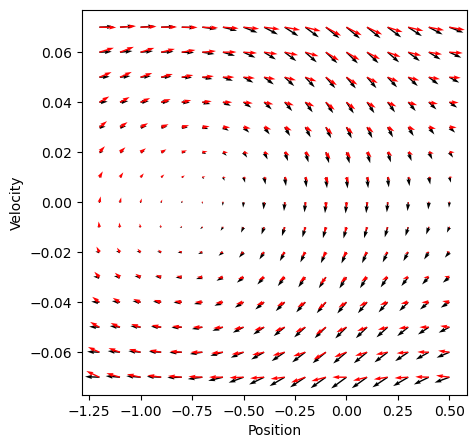

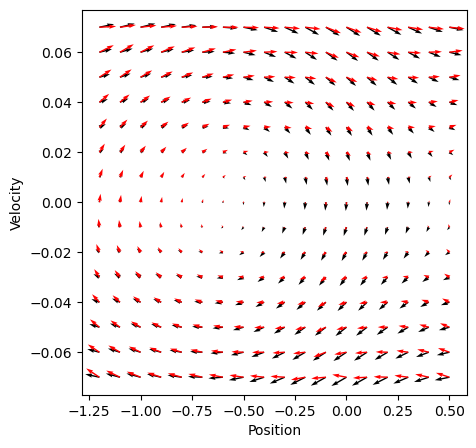

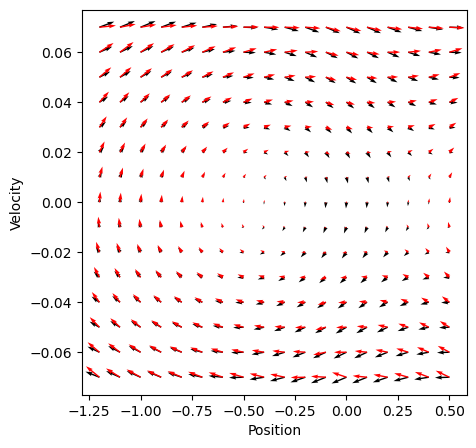

In [17]:
def plot_policy(model,action,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)


    X, V = np.meshgrid(positions, velocities)
    NX = np.zeros_like(X)
    NV = np.zeros_like(V)

    NX_model = np.zeros_like(X)
    NV_model = np.zeros_like(V)

    for i, x in enumerate(positions):
        for j, v in enumerate(velocities):
                nv = v + .001*(action - 1) - .0025*np.cos(3*x) #changed action to 0
                nx = x + nv

                next,_,_,_ = model(torch.tensor([x, v],dtype=torch.float32), torch.tensor([action],dtype=torch.float32))
                next = next.detach().numpy()
                #check if norm((nx, nv) - next) is small
                #assert np.linalg.norm(np.array([nx, nv]) - next) < 0.1
                # if np.linalg.norm(np.array([nx, nv]) - next) > 0.01:
                #      continue
                nx_model, nv_model = next
                NX_model[j, i] = np.round(nx_model, 5)#nx_model
                NV_model[j, i] = np.round(nv_model, 5)#nv_model
                NX[j, i] = np.round(nx, 5)#nx
                NV[j, i] = np.round(nv, 5)#nv
    DX = (NX - X)
    DV = (NV - V)
    DX_model = (NX_model - X)
    DV_model = (NV_model - V)

    #q = ax.quiver(X, V, DX/(DX.max() - DX.min()), DV/(DV.max() - DV.min()))
    #q_model = ax.quiver(X, V, DX_model/(DX_model.max() - DX_model.min()), DV_model/(DV_model.max() - DV_model.min()), color='red')

    total_dx_max = np.max([DX.max(), DX_model.max()])
    total_dx_min = np.min([DX.min(), DX_model.min()])
    total_dy_max = np.max([DV.max(), DV_model.max()])
    total_dy_min = np.min([DV.min(), DV_model.min()])
    q = ax.quiver(X, V, DX, DV,angles='xy' ,scale_units='xy', scale=1)
    q_model = ax.quiver(X, V, DX_model, DV_model, color='red', angles='xy' ,scale_units='xy', scale=1)
    ax.set_box_aspect(1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')

plot_policy(model,-1)
plot_policy(model,0)
plot_policy(model,1)

[[1.         0.99999514]
 [0.99999514 1.        ]]


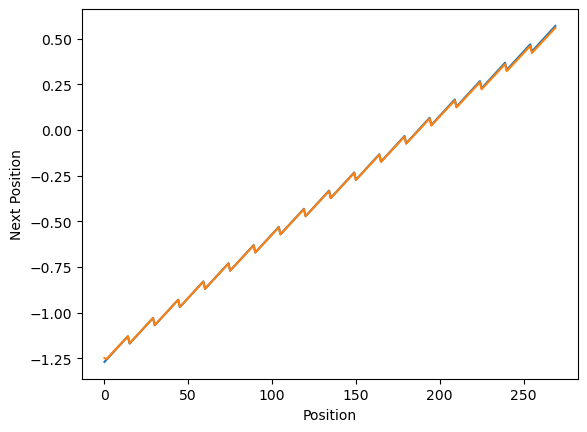

[[1.        0.9995733]
 [0.9995733 1.       ]]


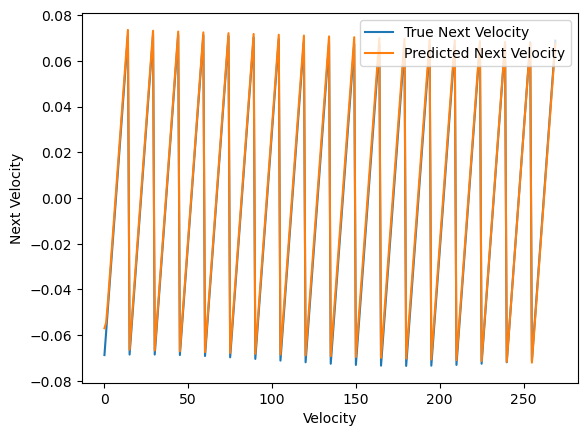

In [ ]:
# #plot true position compared to model position prediction

# def plot_position(model,ax=None):
#     true_positions = np.arange(-1.2, 0.6, .1)
#     velocities = np.arange(-0.07, 0.07, .01)
#     true_next_positions = []
#     true_next_velocities = []
#     for i in true_positions:
#         for j in velocities: 
#             nv = j + .001*(0 - 1) - .0025*np.cos(3*i)
#             nx = i + nv
#             true_next_positions.append(nx)
#             true_next_velocities.append(nv)
#    # print(len(true_next_positions))
#     pred_next_positions = []
#     pred_next_velocities = []
#     for i in true_positions:
#         for j in velocities:
#             next,_,_ = model(torch.tensor([i, j],dtype=torch.float32))
#             nx, nv = next
#             pred_next_positions.append(nx.item())
#             pred_next_velocities.append(nv.item())

#     #print(len(pred_next_positions[0]))
#     plt.plot(true_next_positions, label='True Next Position')
#     plt.plot(pred_next_positions, label='Predicted Next Position')
#     #get correlation
#     print(np.corrcoef(true_next_positions,pred_next_positions))
#     plt.xlabel('Position')
#     plt.ylabel('Next Position')
#     plt.show()

#     plt.plot(true_next_velocities, label='True Next Velocity')
#     plt.plot(pred_next_velocities, label='Predicted Next Velocity')
#     print(np.corrcoef(true_next_velocities,pred_next_velocities))
#     plt.xlabel('Velocity')
#     plt.ylabel('Next Velocity')
#     plt.legend()
#     plt.show()

# plot_position(model)